In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import warnings
import chess.engine
import chess.svg
from IPython.display import display, SVG, clear_output
import time
from tqdm import tqdm
from stockfish import Stockfish
import chess.pgn
import chess
import mmh3
import random
import xgboost as xgb
from math import inf

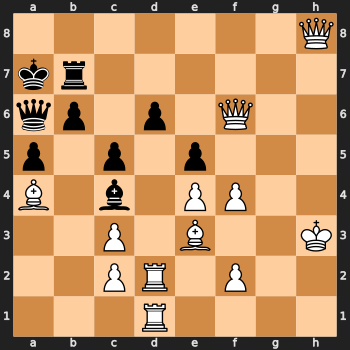

(38.0, 21.5)


In [192]:
# Utility functions
stockfish = Stockfish(path="datasets/chess/stockfish.exe", depth=2)

def board_to_array(board):
    board_array = np.zeros(64, dtype=int)

    piece_map = board.piece_map()
    piece_to_int = {'P': 1, 'p': -1, 'N': 2, 'n': -2, 'B': 3, 'b': -3, 'R': 4, 'r': -4, 'Q': 5, 'q': -5, 'K': 6, 'k': -6}

    for square, piece in piece_map.items():
        board_array[square] = piece_to_int[piece.symbol()]

    return board_array

def calculate_material(board):
    material_white = 0
    material_black = 0

    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 4.5,
        chess.QUEEN: 9,
        chess.KING: 0  # Usually the king is not included in material calculations
    }

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            value = piece_values[piece.piece_type]
            if piece.color == chess.WHITE:
                material_white += value
            else:
                material_black += value

    return material_white, material_black

def count_pieces_by_type_and_color(board):
    piece_count = {
        'white': {'P': 0, 'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K': 0},
        'black': {'p': 0, 'n': 0, 'b': 0, 'r': 0, 'q': 0, 'k': 0}
    }

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            color = 'white' if piece.color == chess.WHITE else 'black'
            piece_count[color][piece.symbol()] += 1

    return piece_count

def generate_feature_vector(board):
    # Initialize an empty list to hold the feature vector
    feature_vector = []

    # Add whose turn it is to the feature vector
    feature_vector.append(int(board.turn))

    # Castling rights
    feature_vector.append(int(board.has_kingside_castling_rights(chess.WHITE)))
    feature_vector.append(int(board.has_queenside_castling_rights(chess.WHITE)))
    feature_vector.append(int(board.has_kingside_castling_rights(chess.BLACK)))
    feature_vector.append(int(board.has_queenside_castling_rights(chess.BLACK)))

    # Add the material imbalance to the feature vector
    white_material, black_material = calculate_material(board)
    feature_vector.append(white_material)
    feature_vector.append(black_material)
    feature_vector.append(white_material - black_material)

    # Add the piece counts to the feature vector
    piece_counts = count_pieces_by_type_and_color(board)

    for piece in ['P', 'N', 'B', 'R', 'Q', 'K']:
        feature_vector.append(piece_counts['white'][piece])
    for piece in ['p', 'n', 'b', 'r', 'q', 'k']:
        feature_vector.append(piece_counts['black'][piece])

    board_array = board_to_array(board)
    feature_vector.extend(board_array)

    return np.array(feature_vector)


def get_stockfish_eval(fen_str):
    stockfish.set_fen_position(fen_str)
    if board.is_game_over():
        return None
    elif stockfish.get_top_moves(3)[0]['Mate'] is not None:
        return None
    else:
        return stockfish.get_top_moves(3)[0]['Centipawn']



# Test the functions
test_fen = '7Q/kr6/qp1p1Q2/p1p1p3/B1b1PP2/2P1B2K/2PR1P2/3R4 b - - 0 48'
board = chess.Board(test_fen)

display(SVG(chess.svg.board(board=board, size=350)))
print(calculate_material(board))




In [244]:
# Create a list to store FEN strings
lst_of_feature_vectors = []
lst_of_fens = []
X = []
y = []
limit = 600
sampling_rate = 1

# Open the PGN files
with open("datasets/chess/lichess_db_standard_rated_2013-02.pgn") as pgn_file:
    count = 0
    for i in tqdm(range(limit)):
        # Read a game from the PGN file
        game = chess.pgn.read_game(pgn_file)
        # Break if no more games are in the file
        if game is None:
            break

        board = game.board()
        for move in game.mainline_moves():
            board.push(move)
            if random.random() < sampling_rate:
                feature_vector = generate_feature_vector(board)
                lst_of_feature_vectors.append(feature_vector)
                y.append(get_stockfish_eval(board.fen()))

X = np.array(lst_of_feature_vectors)
y = np.array(y)

filtered_X = [X[i] for i in range(len(y)) if y[i] is not None]
filtered_y = [val for val in y if val is not None]
X, y = np.array(filtered_X), np.array(filtered_y)


print(X.shape, y.shape)
print(min(y), max(y))
data = np.concatenate([X, y.reshape(-1, 1)], axis=1)
data = pd.DataFrame(data)
print(data.head())
print(data.shape)
data.to_csv("datasets/chess/lichess_eval.csv", index=False, header=False)


100%|██████████| 600/600 [01:37<00:00,  6.17it/s]


(38592, 84) (38592,)
-4770 5379
    0    1    2    3    4     5     6    7    8    9   ...   75   76   77  \
0  0.0  1.0  1.0  1.0  1.0  38.0  38.0  0.0  8.0  2.0  ... -1.0 -4.0 -2.0   
1  1.0  1.0  1.0  1.0  1.0  38.0  38.0  0.0  8.0  2.0  ... -1.0 -4.0 -2.0   
2  0.0  1.0  1.0  1.0  1.0  38.0  37.0  1.0  8.0  2.0  ... -1.0 -4.0 -2.0   
3  1.0  1.0  1.0  1.0  1.0  38.0  37.0  1.0  8.0  2.0  ... -1.0 -4.0 -2.0   
4  0.0  1.0  1.0  1.0  1.0  38.0  36.0  2.0  8.0  2.0  ... -1.0 -4.0 -2.0   

    78   79   80   81   82   83     84  
0 -3.0 -5.0 -6.0 -3.0 -2.0 -4.0   47.0  
1 -3.0 -5.0 -6.0 -3.0 -2.0 -4.0    9.0  
2 -3.0 -5.0 -6.0 -3.0 -2.0 -4.0   51.0  
3 -3.0 -5.0 -6.0 -3.0 -2.0 -4.0   78.0  
4 -3.0 -5.0 -6.0 -3.0 -2.0 -4.0  112.0  

[5 rows x 85 columns]
(38592, 85)


In [3]:
def read_processed_data(filename):
    data = pd.read_csv(filename)
    data.dropna(inplace=True)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

In [246]:


X, y = read_processed_data('datasets/chess/lichess_eval.csv')

print('------------------Data data summary------------------')

print(f'Shapes of X and y: {X.shape}, {y.shape}')
print(f'Max and min of y: {max(y)}, {min(y)}')

print('------------------Training the model------------------')

train_size = int(0.8*len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 8,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'subsample': 0.95,
    'n_jobs': -1
}

print(X_train.shape, y_train.shape)

model = xgb.Booster()
model = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtest, 'test')])
y_pred = model.predict(dtest)
print(mean_absolute_error(y_test, y_pred))
model.save_model('datasets/chess/engine_v1.model')



------------------Data data summary------------------
Shapes of X and y: (38591, 84), (38591,)
Max and min of y: 5379.0, -4770.0
------------------Training the model------------------
(30872, 84) (30872,)
[0]	test-mae:278.31890
[1]	test-mae:259.86628
[2]	test-mae:244.18956
[3]	test-mae:230.82399
[4]	test-mae:219.77233
[5]	test-mae:209.88060
[6]	test-mae:201.49846
[7]	test-mae:194.32393
[8]	test-mae:188.21533
[9]	test-mae:182.43355
[10]	test-mae:177.51828
[11]	test-mae:173.57471
[12]	test-mae:170.51422
[13]	test-mae:167.11470
[14]	test-mae:164.18017
[15]	test-mae:161.62905
[16]	test-mae:159.78158
[17]	test-mae:157.96167
[18]	test-mae:156.08574
[19]	test-mae:154.67498
[20]	test-mae:153.25498
[21]	test-mae:152.24498
[22]	test-mae:151.02645
[23]	test-mae:150.07831
[24]	test-mae:149.36473
[25]	test-mae:148.59034
[26]	test-mae:148.00255
[27]	test-mae:147.36811
[28]	test-mae:146.61705
[29]	test-mae:146.19671
[30]	test-mae:145.81662
[31]	test-mae:145.62959
[32]	test-mae:145.25963
[33]	test-mae

In [247]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

X, y = read_processed_data('datasets/chess/lichess_eval.csv')

X[:, 5] = X[:, 5] / 100
X[:, 6:70] = X[:, 6:70] / 6

train_size = int(0.8*len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

y_train = y_train/10000
y_test = y_test/10000


print(y_train[:10])
print(y_test[:10])

input_size = X_train.shape[1]


X_train = torch.from_numpy(X_train).float().view(-1, input_size)
X_test = torch.from_numpy(X_test).float().view(-1, input_size)
y_train = torch.from_numpy(y_train).float().view(-1, 1)
y_test = torch.from_numpy(y_test).float().view(-1, 1)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



There are 1 GPU(s) available.
[0.0009 0.0051 0.0078 0.0112 0.0174 0.0155 0.0188 0.0228 0.0173 0.0182]
[0.0195 0.0125 0.0172 0.0166 0.022  0.0208 0.0402 0.0369 0.0608 0.0504]
torch.Size([30872, 84]) torch.Size([30872, 1]) torch.Size([7719, 84]) torch.Size([7719, 1])


In [248]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x




In [255]:
EPOCHS = 100

criterion = nn.MSELoss()
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0000001)

def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            difference = output - y
            loss = torch.mean(torch.abs(difference)) * 10000

    return loss
    
min_loss_so_far = float('inf')
early_stopping_counter = 0

for epoch in range(EPOCHS):
    model.train()
    count = 0
    for data in train_loader:
        X, y = data
        X = X.to(device)
        y = y.to(device)
        model.zero_grad()
        output = model(X)
        # print(output)
        # break
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        count += 1
        
    test_loss = evaluate_model(model, test_loader)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch}, Test loss: {test_loss }')
        print(f'min loss so far: {min_loss_so_far}')

    if test_loss < min_loss_so_far:
        min_loss_so_far = test_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 5:
        break

    



Epoch: 0, Test loss: 181.87368774414062
min loss so far: inf
Epoch: 1, Test loss: 138.32879638671875
min loss so far: 181.87368774414062
Epoch: 2, Test loss: 116.20217895507812
min loss so far: 138.32879638671875
Epoch: 3, Test loss: 101.7758560180664
min loss so far: 116.20217895507812
Epoch: 4, Test loss: 90.1181411743164
min loss so far: 101.7758560180664
Epoch: 5, Test loss: 80.20243835449219
min loss so far: 90.1181411743164
Epoch: 6, Test loss: 71.96794891357422
min loss so far: 80.20243835449219
Epoch: 7, Test loss: 64.99942016601562
min loss so far: 71.96794891357422
Epoch: 8, Test loss: 59.21532440185547
min loss so far: 64.99942016601562
Epoch: 9, Test loss: 55.807254791259766
min loss so far: 59.21532440185547
Epoch: 10, Test loss: 53.156288146972656
min loss so far: 55.807254791259766
Epoch: 11, Test loss: 50.886348724365234
min loss so far: 53.156288146972656
Epoch: 12, Test loss: 49.000064849853516
min loss so far: 50.886348724365234
Epoch: 13, Test loss: 47.3362731933593

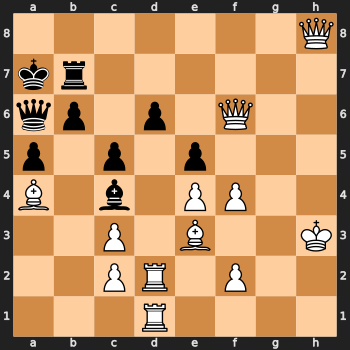

feature vector [[ 0.   0.   0.   0.   0.  38.  21.5 16.5  5.   0.   2.   2.   2.   1.
   5.   0.   1.   1.   1.   1.   0.   0.   0.   4.   0.   0.   0.   0.
   0.   0.   1.   4.   0.   1.   0.   0.   0.   0.   1.   0.   3.   0.
   0.   6.   3.   0.  -3.   0.   1.   1.   0.   0.  -1.   0.  -1.   0.
  -1.   0.   0.   0.  -5.  -1.   0.  -1.   0.   5.   0.   0.  -6.  -4.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   5. ]]
NN eval 715.7179713249207
Stockfish eval 1333


In [256]:
# test 
fen_str = "7Q/kr6/qp1p1Q2/p1p1p3/B1b1PP2/2P1B2K/2PR1P2/3R4 b - - 0 48"
board = chess.Board(fen_str)
display(SVG(chess.svg.board(board=board, size=350)))
feature_vector = generate_feature_vector(board).reshape(1, -1)


print(f'feature vector {feature_vector}')
#feature_vector = xgb.DMatrix(np.array(feature_vector))
#score = model.predict(feature_vector)
feature_vector = torch.from_numpy(feature_vector).float().view(-1, input_size)
feature_vector = feature_vector.to(device)
feature_vector[0][5] = feature_vector[0][5] / 100
feature_vector[0][6:70] = feature_vector[0][6:70] / 6

with torch.no_grad():
    score = model(feature_vector).item()*10000
print(f'NN eval {score}')
engine_score = get_stockfish_eval(fen_str)
print(f'Stockfish eval {engine_score}')


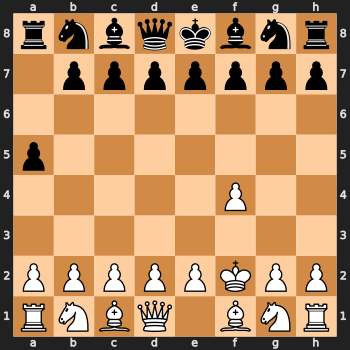

FEN: rnbqkbnr/1ppppppp/8/p7/5P2/8/PPPPPKPP/RNBQ1BNR b kq - 1 2
Stockfish evaluation: -69
Model evaluation: 76.47441700100899
# of search nodes: 439
Current Game in PGN format:
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

1. f4 a5 2. Kf2 *


KeyboardInterrupt: 

In [258]:
import time
from collections import OrderedDict

PIECE_VALUES = {
    chess.PAWN: 1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK: 5,
    chess.QUEEN: 9,
    chess.KING: 100  # Arbitrarily high to ensure the king's safety
}

######################################################
# Find candidate moves


def find_attacking_moves(board):
    # Generate all attacking moves
    attacking_moves = []
    for move in board.legal_moves:
        if board.is_capture(move):
            attacking_moves.append(move)
    return attacking_moves

def find_defending_moves(board):
    defending_moves = []

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is None:
            continue
        if piece.color != board.turn:
            continue

        # Get squares that are attacked by the opponent
        attacked_by_opponent = board.attackers(not board.turn, square)
        if not attacked_by_opponent:
            continue

        # Try all legal moves
        for move in board.legal_moves:
            if board.is_into_check(move):
                continue
            
            board.push(move)
            if board.is_attacked_by(board.turn, square):
                defending_moves.append(move)
            board.pop()

    return defending_moves


def find_moves_for_vulnerable_pieces(board):
    vulnerable_moves = []
    
    for move in board.legal_moves:
        from_square = move.from_square
        to_square = move.to_square

        # Check if the piece at 'from_square' is under attack
        piece = board.piece_at(from_square)
        if piece is None:
            continue

        attackers = board.attackers(not board.turn, from_square)
        if not attackers:
            continue  # Skip if no attackers
        
        defenders = board.attackers(board.turn, from_square)

        # If there are no defenders, add the move
        if len(defenders) == 0:
            vulnerable_moves.append(move)
            continue

        # If there are attackers with lesser value than the piece being attacked, add the move
        for attacker_square in attackers:
            attacker_piece = board.piece_at(attacker_square)
            if attacker_piece is None:
                continue

            if PIECE_VALUES[attacker_piece.piece_type] < PIECE_VALUES[piece.piece_type]:
                vulnerable_moves.append(move)
                break

    return vulnerable_moves

######################################################
# Evaluation function

def evaluate_board(board, engine=False):
    # evaluation function
    if board.is_checkmate() and board.turn == chess.WHITE:
        return -10000
    elif board.is_checkmate() and board.turn == chess.BLACK:
        return 10000
    elif board.is_game_over():
        return 0

    # use engine
    if engine:
        stockfish.set_fen_position(board.fen())  
        if stockfish.get_top_moves(1)[0]['Mate']:
            if board.turn == chess.WHITE:
                return 10000
            else:
                return -10000
        else:
            return stockfish.get_top_moves(1)[0]['Centipawn']
    else:
        # use model
        feature_vector = generate_feature_vector(board)
        feature_vector = np.array(feature_vector).reshape(1, -1)

        feature_vector[:, 5] = feature_vector[:, 5] / 100
        feature_vector[:, 6:70] = feature_vector[:, 6:70] / 6
        feature_vector = torch.from_numpy(feature_vector).float().view(-1, 84)
        feature_vector = feature_vector.to(device)
        with torch.no_grad():
            score = model(feature_vector).item() * 10000
        return score

        # feature_vector = xgb.DMatrix(feature_vector)
        # return model.predict(feature_vector)
        

def get_ordered_moves(board, sample_size=20):

    # Generate all legal moves
    all_moves = list(board.legal_moves)

    capture_moves = []
    check_moves = []
    attacking_moves = find_attacking_moves(board)
    castle_moves = []
    vulnerable_pieces_moves = find_moves_for_vulnerable_pieces(board)
    other_moves = []

    for move in all_moves:
        if board.is_capture(move):
            capture_moves.append(move)
        elif board.gives_check(move):
            check_moves.append(move)
        elif board.is_castling(move):
            castle_moves.append(move)
        else:
            other_moves.append(move)

        ordered_moves = castle_moves + capture_moves + check_moves + attacking_moves +  vulnerable_pieces_moves + other_moves
        ordered_moves_no_duplicates = list(OrderedDict.fromkeys(ordered_moves).keys())

    return ordered_moves_no_duplicates

######################################################
# Search algorithm

hashed_positions = {}

def hash_fen(fen_str):
    return mmh3.hash128(fen_str, signed=False)

def alpha_beta(board, depth, alpha, beta, maximizing, threshold=10000):
    global hashed_positions

    if hash_fen(board.fen()) in hashed_positions:
        return hashed_positions[hash_fen(board.fen())]
    
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)
    
    top_k = 2
    shallow_depth = 2
    candidate_moves = get_ordered_moves(board)

    if maximizing:
        max_eval = float('-inf')
        top_k_moves = []
        
        if depth > shallow_depth:
            # Shallow search to get top-k moves
            for move in candidate_moves:
                board.push(move)
                eval = alpha_beta(board, shallow_depth-1, alpha, beta, False, threshold)
                board.pop()
                top_k_moves.append((move, eval))
            top_k_moves = sorted(top_k_moves, key=lambda x: x[1], reverse=True)[:top_k]
            # Perform deep search for each of the top-k moves
            for move, _ in top_k_moves:
                board.push(move)
                eval = alpha_beta(board, depth-1, alpha, beta, False, threshold)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            hashed_positions[hash_fen(board.fen())] = max_eval  
            return max_eval
        else:
            for move in candidate_moves:
                board.push(move)
                eval = alpha_beta(board, depth-1, alpha, beta, False, threshold)
                board.pop()
                max_eval = max(max_eval, eval)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            hashed_positions[hash_fen(board.fen())] = max_eval
            return max_eval

    else:
        min_eval = float('inf')
        top_k_moves = []

        if depth > shallow_depth:
            # Shallow search to get top-k moves
            for move in candidate_moves:
                board.push(move)
                eval = alpha_beta(board, shallow_depth-1, alpha, beta, True, threshold)
                board.pop()
                top_k_moves.append((move, eval))
            top_k_moves = sorted(top_k_moves, key=lambda x: x[1])[:top_k]
            # Perform deep search for each of the top-k moves
            for move, _ in top_k_moves:
                board.push(move)
                eval = alpha_beta(board, depth-1, alpha, beta, True, threshold)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            hashed_positions[hash_fen(board.fen())] = min_eval
            return min_eval
        else:
            for move in candidate_moves:
                board.push(move)
                eval = alpha_beta(board, depth-1, alpha, beta, False, threshold)
                board.pop()
                min_eval = min(min_eval, eval)
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            hashed_positions[hash_fen(board.fen())] = min_eval
            return min_eval
        

def get_best_move(board):
    # Define the initial depth and top_k for shallow search
    depth = 8
    global hashed_positions
    hashed_positions.clear()
    shallow_depth = 3
    top_k = 4
    
    # Initialize best_eval based on whose turn it is
    if board.turn == chess.WHITE:
        best_eval = float('-inf')
        maximizing = True
    else:
        best_eval = float('inf')
        maximizing = False

    # Perform shallow search to get top_k moves
    shallow_moves = []
    for move in get_ordered_moves(board):
        board.push(move)
        move_eval = alpha_beta(board, shallow_depth-1, float('-inf'), float('inf'), not maximizing)
        board.pop()
        shallow_moves.append((move, move_eval))

    shallow_moves = sorted(shallow_moves, key=lambda x: x[1], reverse=maximizing)[:top_k]
    #candidate_moves = get_ordered_moves(board)

    # Deeper search only on the top_k moves
    best_move = None
    for move, _ in shallow_moves:
        board.push(move)
        move_eval = alpha_beta(board, depth-1, float('-inf'), float('inf'), not maximizing)  # You can set your own deeper depth
        board.pop()
        
        if (maximizing and move_eval > best_eval) or (not maximizing and move_eval < best_eval):
            best_eval = move_eval
            best_move = move

    return best_move

# Initialize 
num_moves = 200

# Initialize an empty PGN
game = chess.pgn.Game()
# Initialize board
board = chess.Board()
# Create a node to represent the game's starting position
node = game
# Play num_moves moves
for i in range(num_moves):
    if board.is_game_over():
        break
    num_search_nodes = 0
    best_move = get_best_move(board=board)
    print(num_search_nodes)
    board.push(best_move)
    print(board.fen())
    node = node.add_variation(best_move)
    print(len(hashed_positions))

    # Clear output
    clear_output(wait=True)
    # Display the board
    
    display(SVG(chess.svg.board(board=board, size=350)))
    print(f'FEN: {board.fen()}')
    print(f'Stockfish evaluation: {get_stockfish_eval(board.fen())}')
    feature_vector = generate_feature_vector(board)
    feature_vector = np.array(feature_vector).reshape(1, -1)


    feature_vector[:, 5] = feature_vector[:, 5] / 100
    feature_vector[:, 6:70] = feature_vector[:, 6:70] / 6
    feature_vector = torch.from_numpy(feature_vector).float().view(-1, 84)
    feature_vector = feature_vector.to(device)
    with torch.no_grad():
        model_score = model(feature_vector).item() * 10000

    # feature_vector = xgb.DMatrix(feature_vector)
    # model_score = model.predict(feature_vector)

    print(f'Model evaluation: {model_score}')
    print(f'# of search nodes: {len(hashed_positions)}')
    # Export the current game state to a PGN string and print it
    pgn_string = str(game)
    print("Current Game in PGN format:")
    print(pgn_string)
    time.sleep(0.1)

exporter = chess.pgn.StringExporter()
pgn_string = game.accept(exporter)


print("PGN of the game:")
print(pgn_string)


In [259]:
torch.save(model, 'model.pth')